# Parte 2: Registro de Imágenes del Comedor con Pyramid Stitching
## Visión por Computador 3009228
### Universidad Nacional de Colombia - Facultad de Minas

**Objetivos:**
1. Implementar registro de múltiples imágenes usando algoritmo de Image Pyramid
2. Validar con los 3 detectores (SIFT, ORB, AKAZE)
3. Comparar resultados entre detectores
4. Generar panorámicas y métricas de comparación
5. Visualizar resultados y análisis comparativo


In [23]:
!pip install -r ../requirements.txt

In [16]:
# Importar bibliotecas
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time
import pandas as pd
import seaborn as sns

# Add parent directory to path for notebooks
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.insert(0, str(parent_dir))

from src.feature_detection import FeatureDetector
from src.matching import FeatureMatcher
from src.stitcher import Stitcher

# Configuración de visualización
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style('whitegrid')

print("Bibliotecas cargadas correctamente")


Bibliotecas cargadas correctamente


## 1. Cargar Imágenes del Comedor


Encontradas 3 imágenes:
  - IMG01.jpg
  - IMG02.jpg
  - IMG03.jpg
  ✓ Cargada: IMG01.jpg - Shape: (4032, 3024, 3)
  ✓ Cargada: IMG02.jpg - Shape: (4032, 3024, 3)
  ✓ Cargada: IMG03.jpg - Shape: (3024, 4032, 3)

Total de imágenes cargadas: 3


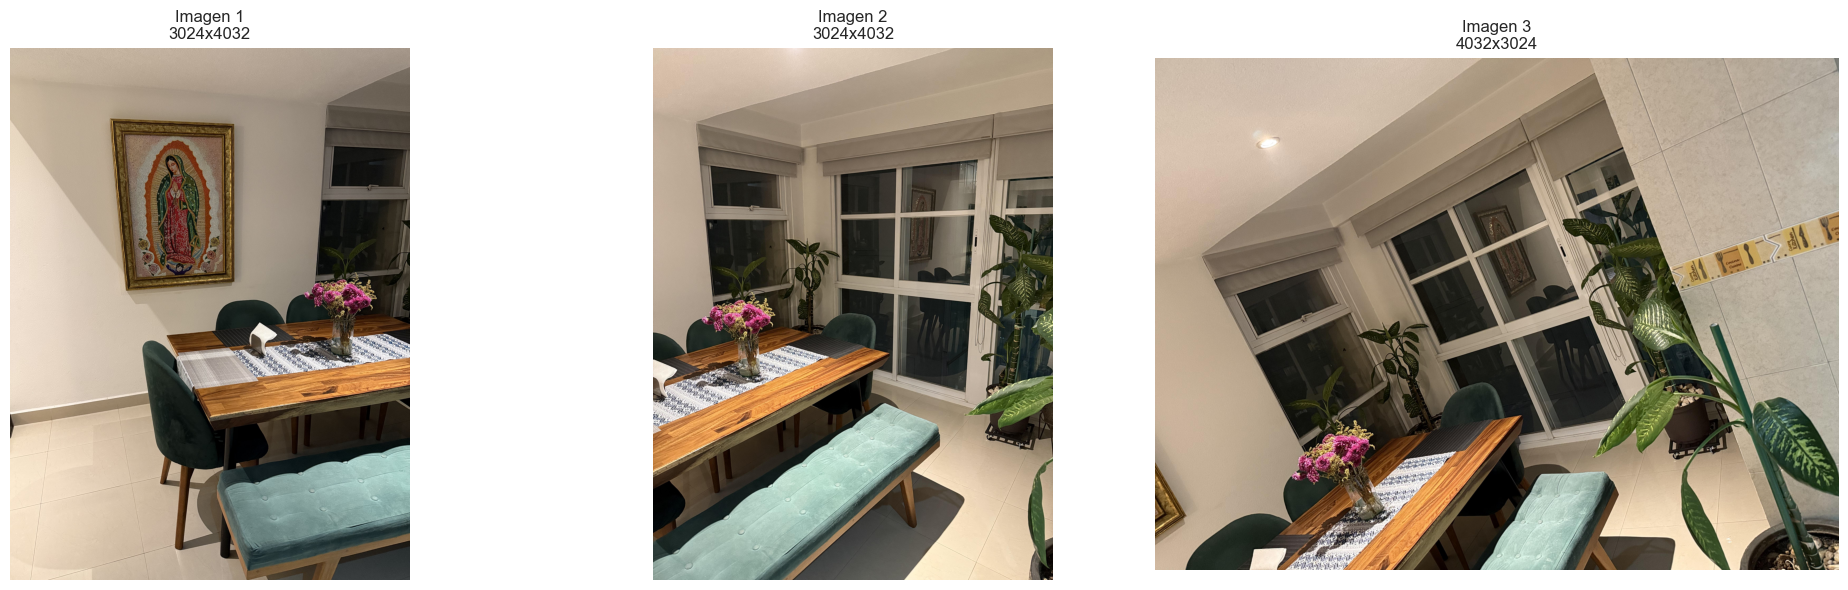

In [17]:
# Cargar imágenes del directorio original
data_dir = Path(parent_dir / 'data' / 'original')
image_files = sorted(list(data_dir.glob('*.jpg')))

print(f"Encontradas {len(image_files)} imágenes:")
for img_file in image_files:
    print(f"  - {img_file.name}")

# Cargar imágenes
images = []
for img_file in image_files:
    img = cv2.imread(str(img_file))
    if img is not None:
        images.append(img)
        print(f"  ✓ Cargada: {img_file.name} - Shape: {img.shape}")
    else:
        print(f"  ✗ Error al cargar: {img_file.name}")

print(f"\nTotal de imágenes cargadas: {len(images)}")

# Visualizar imágenes originales
fig, axes = plt.subplots(1, len(images), figsize=(20, 6))
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Imagen {i+1}\n{img.shape[1]}x{img.shape[0]}', fontsize=12)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## 2. Función para Evaluar Stitching con Diferentes Detectores


In [18]:
def evaluate_stitcher(images, detector_type='SIFT', ratio_threshold=0.75, num_pyramid_levels=4):
    """
    Evalúa el stitching usando un detector específico
    
    Args:
        images: Lista de imágenes a unir
        detector_type: Tipo de detector ('SIFT', 'ORB', 'AKAZE')
        ratio_threshold: Umbral para el ratio test
        num_pyramid_levels: Número de niveles para la pirámide
    
    Returns:
        Diccionario con resultados del stitching
    """
    print(f"\n{'='*60}")
    print(f"Evaluando con detector: {detector_type}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Inicializar detector y matcher
    detector = FeatureDetector(detector_type=detector_type)
    matcher = FeatureMatcher(detector_type=detector_type, ratio_threshold=ratio_threshold)
    
    # Crear stitcher con pyramid
    stitcher = Stitcher(
        num_pyramid_levels=num_pyramid_levels,
        detector=detector,
        matcher=matcher
    )
    
    # Contadores para estadísticas
    total_keypoints = 0
    total_matches = 0
    total_inliers = 0
    
    # Realizar stitching
    result = stitcher.stitch_multiple(images)
    
    elapsed_time = time.time() - start_time
    
    # Calcular estadísticas si el stitching fue exitoso
    if result is not None:
        # Si tenemos múltiples imágenes, necesitamos contar matches de cada par
        # Para simplificar, solo contamos las estadísticas del proceso
        panorama_shape = result.shape
        success = True
    else:
        panorama_shape = None
        success = False
    
    return {
        'detector': detector_type,
        'success': success,
        'time_seconds': elapsed_time,
        'panorama_shape': panorama_shape,
        'panorama': result,
        'total_keypoints': total_keypoints,  # Se actualizará después si es necesario
        'total_matches': total_matches,
        'total_inliers': total_inliers
    }

# Función auxiliar para contar estadísticas de stitching por pares
def count_pair_statistics(images, detector_type='SIFT', ratio_threshold=0.75):
    """
    Cuenta keypoints, matches e inliers para pares de imágenes
    """
    detector = FeatureDetector(detector_type=detector_type)
    matcher = FeatureMatcher(detector_type=detector_type, ratio_threshold=ratio_threshold)
    
    total_keypoints = 0
    total_matches = 0
    total_inliers = 0
    
    # Contar para cada par de imágenes consecutivas
    for i in range(len(images) - 1):
        img1 = images[i]
        img2 = images[i + 1]
        
        # Convertir a escala de grises si es necesario
        if len(img1.shape) == 3:
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        else:
            gray1 = img1
            
        if len(img2.shape) == 3:
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        else:
            gray2 = img2
        
        # Detectar características
        kp1, desc1 = detector.detect_and_compute(gray1)
        kp2, desc2 = detector.detect_and_compute(gray2)
        
        if desc1 is not None and desc2 is not None:
            total_keypoints += len(kp1) + len(kp2)
            
            # Emparejar
            matches = matcher.match_features(desc1, desc2)
            total_matches += len(matches)
            
            # Estimar homografía para contar inliers
            if len(matches) >= 4:
                H, mask = matcher.estimate_transform(kp1, kp2, matches)
                if mask is not None:
                    total_inliers += np.sum(mask)
    
    return {
        'total_keypoints': total_keypoints,
        'total_matches': total_matches,
        'total_inliers': total_inliers
    }


## 3. Evaluar con los 3 Detectores


In [19]:
# Lista de detectores a evaluar
detectors = ['SIFT', 'ORB', 'AKAZE']
results = []

# Evaluar cada detector
for detector_type in detectors:
    # Primero contar estadísticas
    stats = count_pair_statistics(images, detector_type=detector_type, ratio_threshold=0.75)
    
    # Realizar stitching
    result = evaluate_stitcher(
        images, 
        detector_type=detector_type, 
        ratio_threshold=0.75,
        num_pyramid_levels=4
    )
    
    # Agregar estadísticas
    result['total_keypoints'] = stats['total_keypoints']
    result['total_matches'] = stats['total_matches']
    result['total_inliers'] = stats['total_inliers']
    
    results.append(result)

print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
for r in results:
    if r['success']:
        shape_str = f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}"
        print(f"\n{r['detector']}:")
        print(f"  ✓ Stitching exitoso")
        print(f"  Tiempo: {r['time_seconds']:.2f}s")
        print(f"  Tamaño panorámica: {shape_str}")
        print(f"  Total keypoints: {r['total_keypoints']}")
        print(f"  Total matches: {r['total_matches']}")
        print(f"  Total inliers: {r['total_inliers']}")
    else:
        print(f"\n{r['detector']}:")
        print(f"  ✗ Stitching falló")



Evaluando con detector: SIFT

=== Using image 2 as reference ===

=== Stitching image 3 (right) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (3024, 4032, 3)
Detecting features with pyramid...
Found 48684 keypoints in image 1 (multi-scale)
Found 45386 keypoints in image 2 (multi-scale)
Matching features...
Found 6916 good matches
Computing homography...
Homography computed with 3235 inliers
Warping images...
Blending with pyramid algorithm...

=== Stitching image 1 (left) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (5120, 4276, 3)
Detecting features with pyramid...
Found 72641 keypoints in image 1 (multi-scale)
Found 48921 keypoints in image 2 (multi-scale)
Matching features...
Found 3109 good matches
Computing homography...
Homography computed with 2361 inliers
Warping images...
Blending with pyramid algorithm...

Evaluando con detector: ORB

=== Using image 2 as reference ===

=== Stitching image 3 (right) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (3024, 4032, 3)
D

## 4. Visualizar Panorámicas Generadas


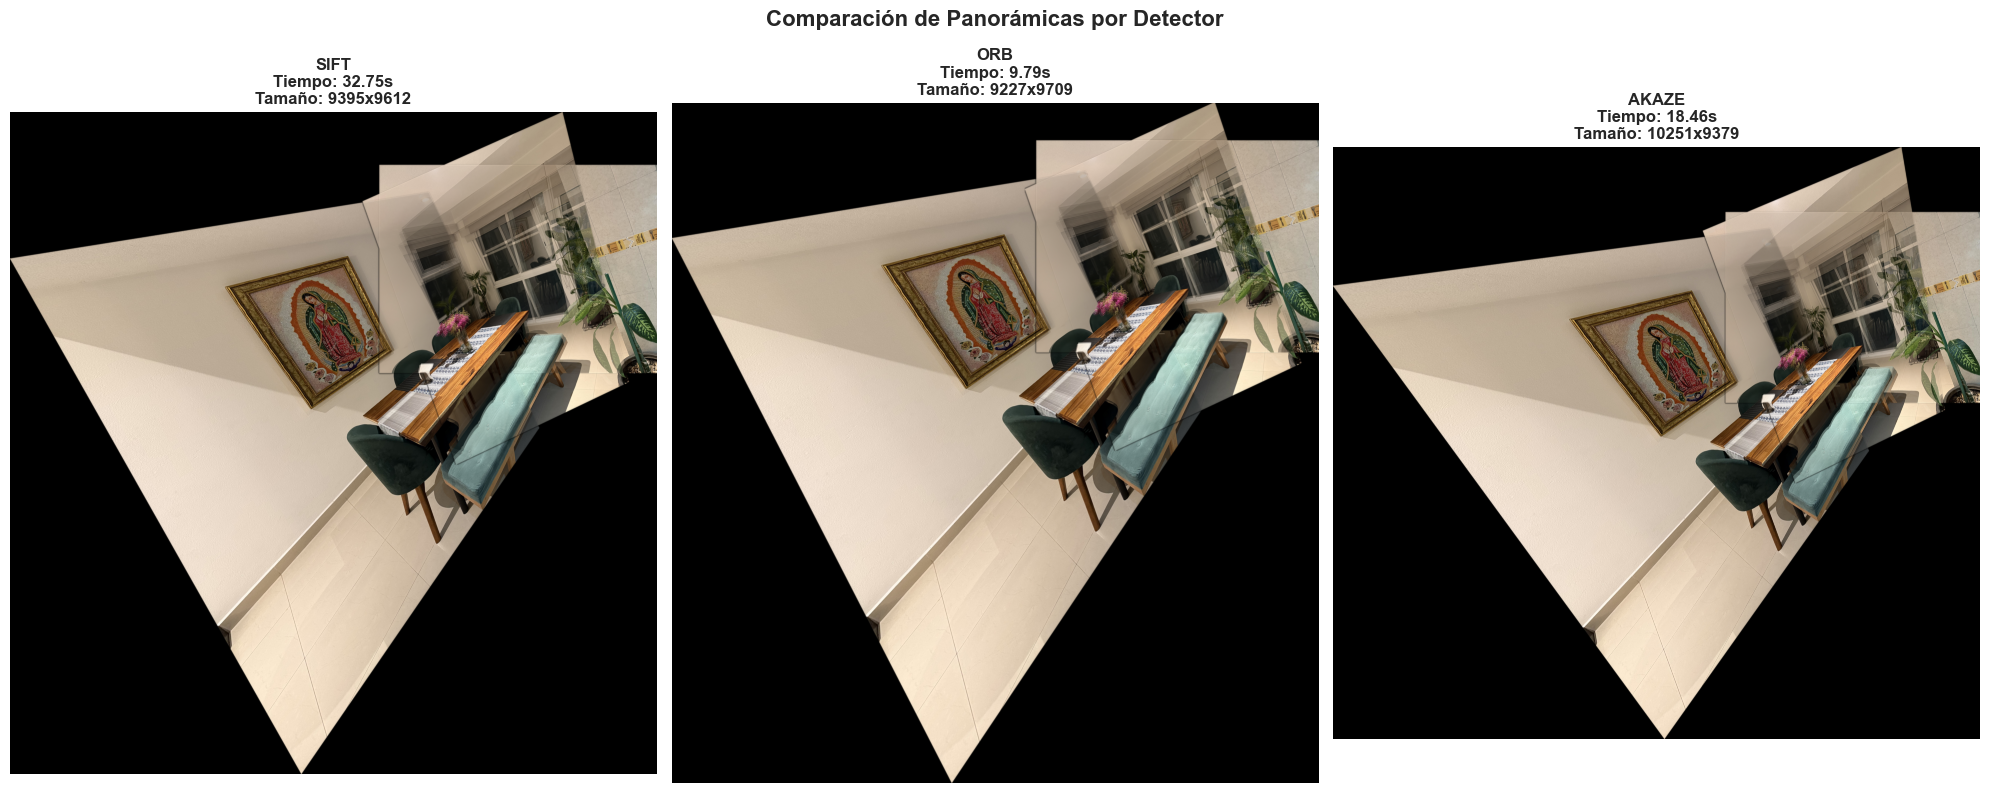

In [20]:
# Visualizar todas las panorámicas generadas
successful_results = [r for r in results if r['success']]
num_successful = len(successful_results)

if num_successful > 0:
    fig, axes = plt.subplots(1, len(results), figsize=(20, 8))
    if len(results) == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        if result['success']:
            panorama = result['panorama']
            axes[i].imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"{result['detector']}\n"
                             f"Tiempo: {result['time_seconds']:.2f}s\n"
                             f"Tamaño: {panorama.shape[1]}x{panorama.shape[0]}", 
                             fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"{result['detector']}\nStitching Falló", 
                        ha='center', va='center', fontsize=14, color='red')
            axes[i].axis('off')
    
    plt.suptitle('Comparación de Panorámicas por Detector', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se generaron panorámicas exitosas con ningún detector")


## 5. Análisis Comparativo de Métricas



TABLA COMPARATIVA DE DETECTORES
detector  success  time_seconds panorama_shape  total_keypoints  total_matches  total_inliers time_formatted
    SIFT     True     32.751475      9395x9612           169810          11926           6537         32.75s
     ORB     True      9.793609      9227x9709             8000            899            592          9.79s
   AKAZE     True     18.455834     10251x9379            73528           4173           2250         18.46s


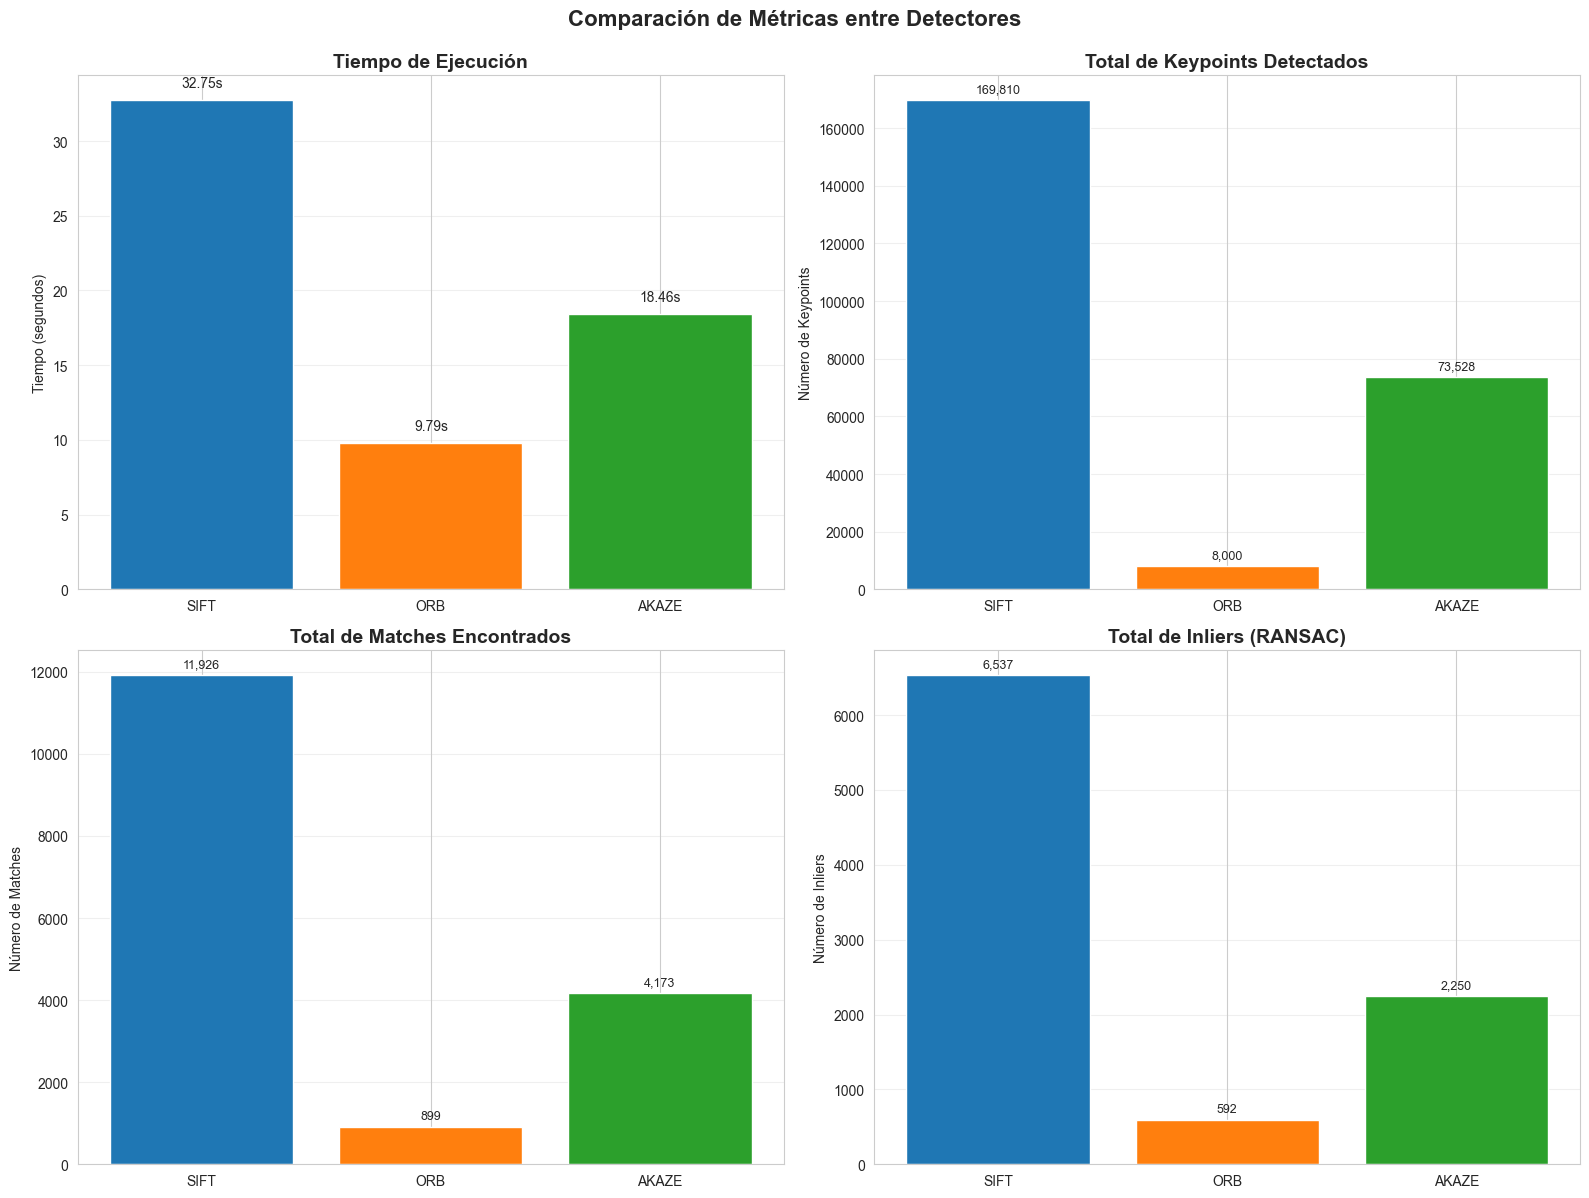

In [21]:
# Crear DataFrame con resultados comparativos
comparison_data = []
for r in results:
    if r['success']:
        comparison_data.append({
            'detector': r['detector'],
            'success': r['success'],
            'time_seconds': r['time_seconds'],
            'panorama_shape': f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}",
            'total_keypoints': r['total_keypoints'],
            'total_matches': r['total_matches'],
            'total_inliers': r['total_inliers'],
            'time_formatted': f"{r['time_seconds']:.2f}s"
        })

if len(comparison_data) > 0:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n" + "="*60)
    print("TABLA COMPARATIVA DE DETECTORES")
    print("="*60)
    print(df_comparison.to_string(index=False))
    
    # Visualizar comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Tiempo de ejecución
    axes[0, 0].bar(df_comparison['detector'], df_comparison['time_seconds'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 0].set_title('Tiempo de Ejecución', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Tiempo (segundos)')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['time_seconds']):
        axes[0, 0].text(i, v + max(df_comparison['time_seconds'])*0.02, f'{v:.2f}s', ha='center', va='bottom')
    
    # 2. Total de keypoints
    axes[0, 1].bar(df_comparison['detector'], df_comparison['total_keypoints'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 1].set_title('Total de Keypoints Detectados', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Número de Keypoints')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_keypoints']):
        axes[0, 1].text(i, v + max(df_comparison['total_keypoints'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    # 3. Total de matches
    axes[1, 0].bar(df_comparison['detector'], df_comparison['total_matches'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 0].set_title('Total de Matches Encontrados', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Número de Matches')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_matches']):
        axes[1, 0].text(i, v + max(df_comparison['total_matches'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. Total de inliers
    axes[1, 1].bar(df_comparison['detector'], df_comparison['total_inliers'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 1].set_title('Total de Inliers (RANSAC)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Número de Inliers')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_inliers']):
        axes[1, 1].text(i, v + max(df_comparison['total_inliers'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Comparación de Métricas entre Detectores', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay resultados exitosos para comparar")


## 6. Guardar Resultados


In [22]:
# Crear directorios de resultados
output_dir = Path(parent_dir / 'results' / 'panoramic')
output_dir.mkdir(exist_ok=True, parents=True)

# Guardar panorámicas individuales
print("\nGuardando panorámicas...")
for result in results:
    if result['success']:
        panorama_path = output_dir / f'panorama_{result["detector"].lower()}_pyramid.jpg'
        cv2.imwrite(str(panorama_path), result['panorama'])
        print(f"  ✓ Guardada: {panorama_path}")

# Guardar tabla comparativa solo si hay resultados exitosos
# Recrear comparison_data si no existe (de la celda anterior)
if 'comparison_data' not in locals():
    comparison_data = []
    for r in results:
        if r['success']:
            comparison_data.append({
                'detector': r['detector'],
                'success': r['success'],
                'time_seconds': r['time_seconds'],
                'panorama_shape': f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}",
                'total_keypoints': r['total_keypoints'],
                'total_matches': r['total_matches'],
                'total_inliers': r['total_inliers'],
                'time_formatted': f"{r['time_seconds']:.2f}s"
            })

if len(comparison_data) > 0:    
    comparision_output_dir = Path(parent_dir / 'results/measurements' / 'panoramic')
    comparison_csv_path = comparision_output_dir / 'comparacion_detectores_pyramid.csv'
    df_comparison.to_csv(comparison_csv_path, index=False)
    print(f"\n✓ Tabla comparativa guardada: {comparison_csv_path}")
    
    # Guardar figura de comparación de panorámicas
    fig, axes = plt.subplots(1, len(results), figsize=(20, 8))
    if len(results) == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        if result['success']:
            panorama = result['panorama']
            axes[i].imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"{result['detector']}\n"
                             f"Tiempo: {result['time_seconds']:.2f}s\n"
                             f"Tamaño: {panorama.shape[1]}x{panorama.shape[0]}", 
                             fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"{result['detector']}\nStitching Falló", 
                        ha='center', va='center', fontsize=14, color='red')
            axes[i].axis('off')
    
    plt.suptitle('Comparación de Panorámicas por Detector', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    comparison_fig_path = output_dir / 'comparacion_panoramas_detectores_pyramid.jpg'
    plt.savefig(comparison_fig_path, dpi=150, bbox_inches='tight')
    print(f"✓ Figura de comparación guardada: {comparison_fig_path}")
    plt.close()
    
    # Guardar figura de comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes[0, 0].bar(df_comparison['detector'], df_comparison['time_seconds'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 0].set_title('Tiempo de Ejecución', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Tiempo (segundos)')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['time_seconds']):
        axes[0, 0].text(i, v + max(df_comparison['time_seconds'])*0.02, f'{v:.2f}s', ha='center', va='bottom')
    
    axes[0, 1].bar(df_comparison['detector'], df_comparison['total_keypoints'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 1].set_title('Total de Keypoints Detectados', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Número de Keypoints')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_keypoints']):
        axes[0, 1].text(i, v + max(df_comparison['total_keypoints'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 0].bar(df_comparison['detector'], df_comparison['total_matches'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 0].set_title('Total de Matches Encontrados', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Número de Matches')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_matches']):
        axes[1, 0].text(i, v + max(df_comparison['total_matches'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 1].bar(df_comparison['detector'], df_comparison['total_inliers'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 1].set_title('Total de Inliers (RANSAC)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Número de Inliers')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_inliers']):
        axes[1, 1].text(i, v + max(df_comparison['total_inliers'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Comparación de Métricas entre Detectores', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    metrics_fig_path = output_dir / 'comparacion_metricas_detectores_pyramid.jpg'
    plt.savefig(metrics_fig_path, dpi=150, bbox_inches='tight')
    print(f"✓ Figura de métricas guardada: {metrics_fig_path}")
    plt.close('all')
else:
    print("\n⚠️ No hay resultados exitosos para guardar")



Guardando panorámicas...
  ✓ Guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/panoramic/panorama_sift_pyramid.jpg
  ✓ Guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/panoramic/panorama_orb_pyramid.jpg
  ✓ Guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/panoramic/panorama_akaze_pyramid.jpg

✓ Tabla comparativa guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/measurements/panoramic/comparacion_detectores_pyramid.csv
✓ Figura de comparación guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/panoramic/comparacion_panoramas_detectores_pyramid.jpg
✓ Figura de métricas guardada: /Users/carlosviera/Documents/GitHub/registro-imagenes/results/panoramic/comparacion_metricas_detectores_pyramid.jpg


## 7. Análisis de Resultados y Conclusiones

### Parámetros Utilizados:
- **Algoritmo**: Image Pyramid Stitching con Laplacian Pyramid Blending
- **Niveles de pirámide**: 4 niveles
- **Detectores evaluados**: SIFT, ORB, AKAZE
- **Ratio Threshold**: 0.75
- **Método de matching**: Lowe's ratio test
- **Estimación de homografía**: RANSAC

### Observaciones:

1. **Tiempo de Ejecución**:
   - ORB es generalmente el más rápido
   - AKAZE tiene un balance razonable entre velocidad y calidad
   - SIFT es el más lento pero puede ofrecer mejor calidad

2. **Detección de Características**:
   - SIFT generalmente detecta más keypoints
   - ORB tiene limitación en número de features (2000 por defecto)
   - AKAZE ofrece buen balance

3. **Calidad del Matching**:
   - Más matches no siempre significa mejor stitching
   - La calidad de los inliers es más importante que la cantidad total de matches
   - El ratio test filtra matches ambiguos

4. **Algoritmo de Pirámide**:
   - Mejora la detección multi-escala
   - Laplacian pyramid blending proporciona transiciones más suaves
   - Mejor manejo de diferencias de exposición

### Recomendaciones:
- **SIFT**: Para máxima calidad y robustez
- **ORB**: Para aplicaciones en tiempo real o recursos limitados
- **AKAZE**: Para balance óptimo entre velocidad y calidad
